# Ice area correlation plots

This notebook demonstrates some ways in which ice area correlation plots can be created using Python, using ice area from a single LENS ensemble member (#13 for years 1920-2005).  
  
The file path is stored in variable `cesm_data`. To run this notebook yourself create a subfolder called 'cesm_data' that contains your model output file.  
  
There area several ways to obtain CESM LENS output. See http://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html for more information. I used https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.ice.proc.monthly_ave.html to download this file.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr
# fix for Basemap issue in anaconda
# see https://ctcoding.wordpress.com/2019/01/29/solved-proj_lib-error-when-installing-basemap-on-windows-using-anaconda/
import os
os.environ['PROJ_LIB'] = r'C:\Users\Ana\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap

In [4]:
def correlate(tseries):
    ''' Returns lagged correlation statistics for all months in tseries
    
    Parameters:
    tseries: 12xnyears sized time series (can be DataArray or numpy array)
    
    Returns:
    r: 12x13 numpy array of correlation coefficients
    p: 12x13 numpy array of significance values
    
    '''
    maxstep = 13
    end = len(tseries)
    r = np.zeros((12,maxstep))
    p = np.zeros((12,maxstep))
    print(r.shape)
    for month in range(0,12,1):
        for step in range(0,maxstep,1):
            if (month > 10 and step > 0):
                # subtract a year from month1
                month1 = tseries[month:end-1:12]
                month2 = tseries[month+step:end:12]
            elif (month + step) > 11:
                # subtract two years from month1
                month1 = tseries[month:end-13:12]
                month2 = tseries[month+step:end:12]
            else:
                # timseries already same length
                month1 = tseries[month:end:12]
                month2 = tseries[month+step:end:12]   
            (r[month,step],p[month,step]) = stats.pearsonr(month1,month2)
    return r,p

In [12]:
def correlation_plot(r,p,region):
    ''' Generate a lagged correlation plot
    
    Parameters:
    r: 12x13 numpy array of correlation coefficients
    p: 12x13 numpy array of significance values
    region: string of region name for plot title
    
    '''
    
    # get locations where p < 0.05
    [x,y] = np.where(p < 0.05)
    
    # plot the month x month correlation coefficients
    fig = plt.figure(figsize = [8/1.5, 6/1.5])
    axes = fig.add_subplot(111) 
    caxes = axes.imshow(r, cmap = 'Oranges', vmin = np.min(r), vmax = np.max(r))
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan']
    
    fig.colorbar(caxes, ticks = [0.1,0.3,0.5,0.7,0.9])
    
    axes.scatter(y,x,marker = '.',color = 'black', s = 2)
    
    axes.set_ylabel('Initial Month')
    axes.set_xlabel('Lag (months)')
    axes.set_xticks(np.linspace(0,12,num=13))
    axes.set_yticks(np.linspace(0,11,num=12))
    axes.set_xticklabels(range(0,13)) 
    axes.set_yticklabels(months)
    axes.xaxis.set_ticks_position('bottom')
    
    plt.title('Monthly average ' + region + ' ice area correlation')

## Ice area time series

Text(0.5, 1.0, 'Monthly average total Arctic ice area')

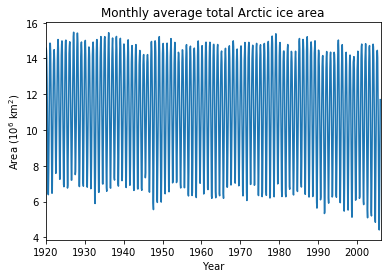

In [6]:
# Load ice area data
cesm_data = 'cesm_data/b.e11.B20TRC5CNBDRD.f09_g16.013.cice.h.aice_nh.192001-200512.nc'
aice = xr.open_dataset(cesm_data)
aice['ice_area'] = aice['aice'] * aice['tarea'] / 100
total_area = aice['ice_area'].sum(dim = ['ni','nj'])

# Plot the monthly average total ice area time series
plt.plot(total_area * 1e-12)
plt.xticks(range(0,len(total_area),12*10),labels = range(1920,2005,10))
plt.xlim([0,len(total_area)])
plt.xlabel('Year')
plt.ylabel('Area (10$^6$ km$^2$)')
plt.title('Monthly average total Arctic ice area')

Text(0.5, 1.0, 'Monthly average total Arctic ice area (1920-2005)')

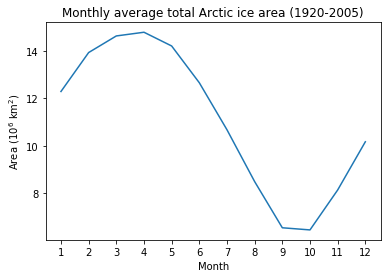

In [7]:
# Plot average monthly ice area
avg_area = aice['ice_area'].sum(dim = ['ni','nj']).groupby('time.month').mean(dim = 'time')

plt.plot(avg_area * 1e-12)
plt.xticks(range(0,12),labels = range(1,13))
plt.xlabel('Month')
plt.ylabel('Area (10$^6$ km$^2$)')
plt.title('Monthly average total Arctic ice area (1920-2005)')

Text(0.5, 1.0, 'Monthly average total GIN Seas ice area')

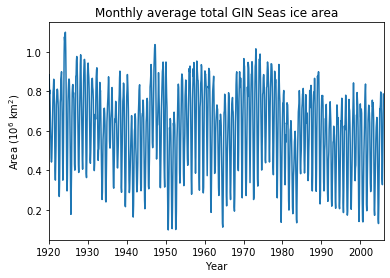

In [8]:
# Extract ice area for just one region (GIN Seas)
seamask = np.load('ice_region_mask.npy')
aice['regionmask'] = (('nj','ni'),seamask)
total_area_g = aice['ice_area'].where(aice['regionmask'] == 1).sum(dim = ['ni','nj'])

# Plot the Greenland region monthly ice area
plt.plot(total_area_g * 1e-12)
plt.xticks(range(0,len(total_area),12*10),labels = range(1920,2005,10))
plt.xlim([0,len(total_area)])
plt.xlabel('Year')
plt.ylabel('Area (10$^6$ km$^2$)')
plt.title('Monthly average total GIN Seas ice area')

## Lag correlation plots

(12, 13)


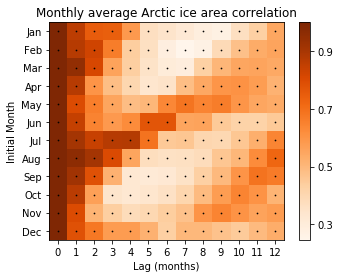

In [9]:
# Generate lagged monthly correlation plot for whole Arctic area
# Dots indicate correlation significance p < 0.05
r,p = correlate(total_area)
correlation_plot(r,p,'Arctic')

(12, 13)


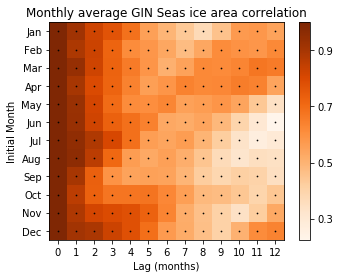

In [13]:
# Generate lagged monthly correlation plot for Greenland area
# Dots indicate correlation significance p < 0.05
r,p = correlate(total_area_g)
correlation_plot(r,p,'GIN Seas')